In [5]:
import os
from tensorflow import keras
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import date, timedelta
import yfinance as yf

TIMESTEPS = 21
FEATURES = 5
PREDICT_DAYS = 8
MAX_EPOCHS = 100

def print_results(r):
  print("DAY     OPEN     HIGH      LOW    CLOSE   ADJ-CL")
  print("--- -------- -------- -------- -------- -------- ")
  for i, v in enumerate(r):
    print("{:<3} ".format(i), end="")
    print(("{:8.2f} "*5).format(*v))

def predict(stock_code):
  today = str((date.today()-timedelta(days=0)))
  end_date = today
  start_date = "2020" + today[4:]
  path = os.path.join("data", f'{stock_code}.csv')
  if not os.path.exists(path):
    print(f"Downloading {stock_code} data from {start_date} to {end_date}")
    data = yf.download(stock_code, start=start_date, end=end_date)
    data.to_csv(path)


  data = pd.read_csv(path)

  data.pop("Volume")
  data.pop("Date")
  arr = np.array(data)
  inputs, target = [], []
  for i in range(len(arr)-TIMESTEPS):
    inputs.append(arr[i:i+TIMESTEPS])
    target.append(arr[i+TIMESTEPS])


  x_train, x_test, y_train, y_test = train_test_split(np.array(inputs), np.array(target), test_size=0.2, shuffle=False)

  plt.plot(data.index, data['Close'])

  model = keras.Sequential([
    keras.layers.Input((TIMESTEPS, FEATURES)),
    keras.layers.LSTM(128),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(FEATURES)
  ])
  model.summary()
  model.compile(loss='mse', 
                optimizer=keras.optimizers.Adam(learning_rate=0.001),
                metrics=['mae'])

  model.fit(x_train, y_train, batch_size=16, epochs=MAX_EPOCHS, validation_data=(x_test, y_test),
              callbacks=[
                EarlyStopping(
                    monitor="loss",
                    patience=MAX_EPOCHS//10,
                    restore_best_weights=True,
                    start_from_epoch=8,
                ),
                EarlyStopping(
                    monitor="val_loss",
                    patience=MAX_EPOCHS//10,
                    restore_best_weights=True,
                    start_from_epoch=8,
                ),
            ],
            )

  results = []
  current_input = []
  for i in range(TIMESTEPS-1, -1, -1):
    index = len(data)-i-1
    current_input.append(data.iloc[index])

  results.append(current_input[-1])
  for i in range(PREDICT_DAYS):
    output = model.predict(np.array([current_input]), verbose=0)
    results.append(list(output[0]))
    current_input.pop(0)
    current_input.append(output[0])
  print_results(results)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               68608     
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 75,013
Trainable params: 75,013
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
37/37 [==============================] -

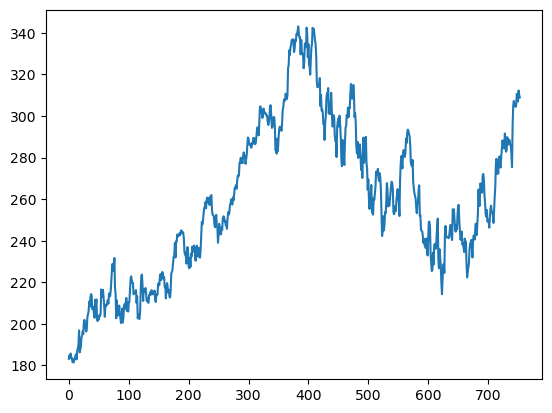

In [6]:
predict("MSFT")